In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [11]:
def TickerIntoTensor(ticker='aapl',daysago=100,daysforward=10,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-daysforward-1,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(daysforward).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
    split = int(len(X)*split_percentage)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,daysforward,1)), Y_test.reshape((-1,daysforward,1))
    #X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), torch.tensor(Y_train).float(), torch.tensor(Y_test).float()
    return X_train, X_test, Y_train, Y_test
TickerIntoTensor()

(array([[[3.09576869e-04],
         [2.83417267e-04],
         [2.48533487e-04],
         ...,
         [2.76972865e-04],
         [2.63396966e-04],
         [2.69428538e-04]],
 
        [[2.83417267e-04],
         [2.48533487e-04],
         [2.59433459e-04],
         ...,
         [2.64843574e-04],
         [2.69428538e-04],
         [2.73449656e-04]],
 
        [[2.48533487e-04],
         [2.59433459e-04],
         [2.72517370e-04],
         ...,
         [2.70908272e-04],
         [2.73449656e-04],
         [2.63396966e-04]],
 
        ...,
 
        [[2.66675806e-01],
         [2.70782804e-01],
         [2.69385213e-01],
         ...,
         [3.71146956e-01],
         [3.69210638e-01],
         [3.62446901e-01]],
 
        [[2.70782804e-01],
         [2.69385213e-01],
         [2.68073455e-01],
         ...,
         [3.71238387e-01],
         [3.62446901e-01],
         [3.67698736e-01]],
 
        [[2.69385213e-01],
         [2.68073455e-01],
         [2.74387127e-01],
         

In [9]:
ticker='aapl'
daysago=100
daysforward=1
split_percentage=0.9
df = yf.Ticker(ticker.upper())
df = df.history(period='max')
if df.shape[1] == 7:
    df = df.drop(columns=['Dividends','Stock Splits'])
df = df.drop(columns=['Open','High','Low','Volume'])
for i in range(daysago,-daysforward-1,-1):
    df['{}daysago'.format(i)] = df['Close'].shift(i)
    df = df.copy()
df = df.drop(columns=['Close'])
df = df.drop(index=df.tail(daysforward).index)
df = df.drop(index=df.head(daysago).index)
print(df.shape[1] == daysago+1+daysforward)
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(df)
X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
print(Y.shape)
split = int(len(X)*split_percentage)
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,daysforward,1)), Y_test.reshape((-1,daysforward,1))

print(Y_train.shape)

True
(10877, 1)
(9789, 1, 1)


In [4]:
model1 = Sequential()
model1.add(InputLayer((101, 1)))
model1.add(LSTM(500))
model1.add(Dense(150, 'sigmoid'))
model1.add(Dense(1, 'linear'))

cp1 = ModelCheckpoint('model/.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, callbacks=[cp1])

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 61s 199ms/step - loss: 1.2366 - root_mean_squared_error: 0.9976 - val_loss: 0.4301 - val_root_mean_squared_error: 0.6558
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 65s 212ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.4260 - val_root_mean_squared_error: 0.6527
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 66s 215ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 69s 227ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.4333 - val_root_mean_squared_error: 0.6582
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 71s 231ms/step - loss: 0.0031 - root_mean_squared_error: 0.0548 - val_loss: 0.1523 - val_root_mean_squared_error: 0.3903
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 68s 221ms/step - loss: 2.2652e-04 - root_mean_squared_error: 0.0150 - val_loss: 0.1479 - val_root_mean_squared_error: 0.3846
Epoch 7/10
306/306 ━━━━━━━━━━━

In [5]:
from tensorflow.keras.models import load_model
model1 = load_model('model/.keras')
y_pred = model1.predict(TickerIntoTensor('goog')[1])
Y_test = TickerIntoTensor('goog')[3].reshape(-1,10)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100

print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
332.0222528381132
-332.0222528381132


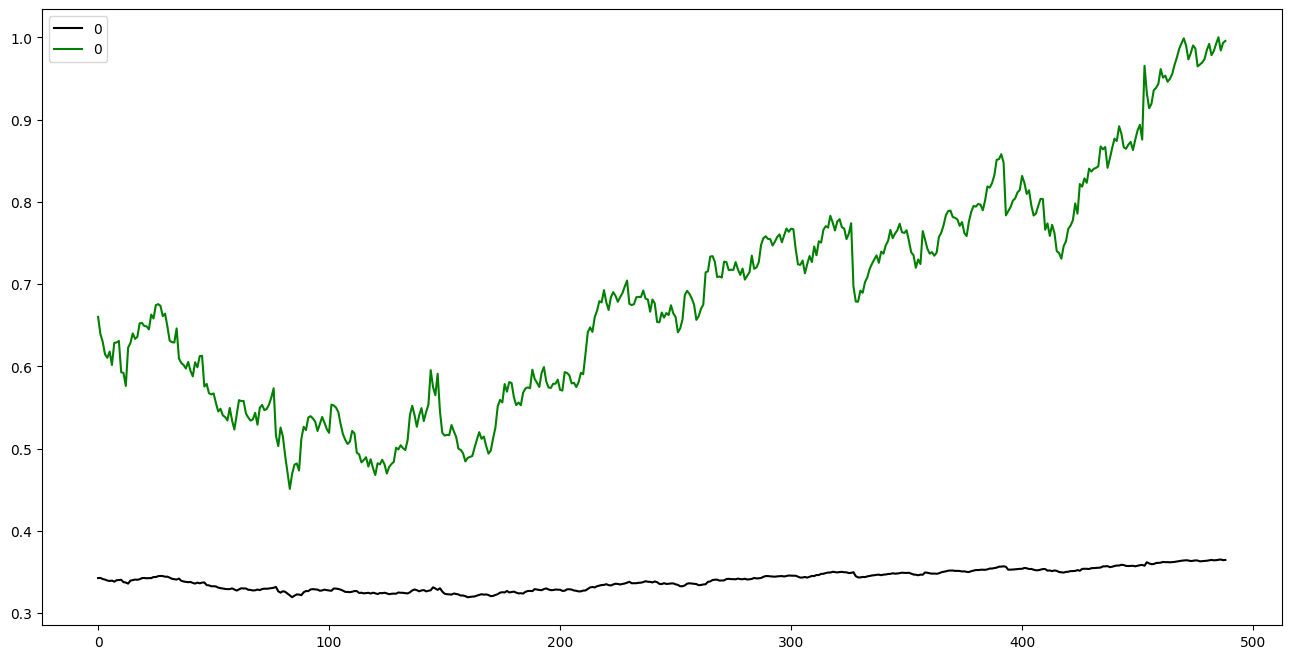

In [6]:
y_pred,Y_test = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('black','green'))
    

In [7]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        75,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,237,905 (12.35 MB)

 Trainable params: 1,079,301 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,158,604 (8.23 MB)